In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg, scipy.stats
import collections

# Simulate a Hawkes process

In [2]:
class Hawkes():
    def __init__(self):
        self.mu = 0.1
        self.theta = 0.5
        self.omega = 1

    def intensity(self, past, t):
        past = np.asarray(past)
        past = past[past < t]
        return self.mu + self.theta * self.omega * np.sum(np.exp(-self.omega * (t-past)))
        
    def next_event(self, past_events, T):
        t = T
        while True:
            max_intensity = self.intensity(past_events, t) + self.theta
            td = np.random.exponential(scale=1/max_intensity)
            if np.random.random() * max_intensity <= self.intensity(past_events, t+td):
                return t+td
            t += td
            
    def simulate(self, previous_events, Tstart, Tend):
        points = []
        all_points = list(previous_events)
        while True:
            t = points[-1] if len(points) > 0 else Tstart
            points.append( self.next_event(points, t) )
            all_points.append(points[-1])
            if points[-1] > Tend:
                break
        return np.asarray(points)

In [3]:
hawkes = Hawkes()
points = hawkes.simulate([], 0, 10000)

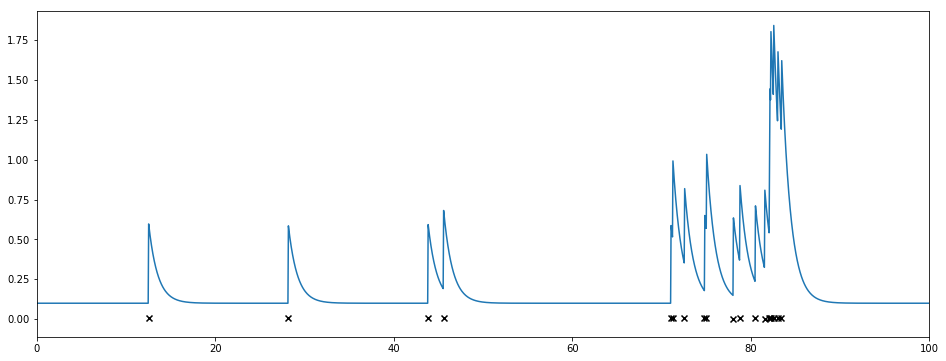

In [4]:
fig, ax = plt.subplots(figsize=(16,6))

x = np.linspace(0, 105, 2000)
y = [hawkes.intensity(points, t) for t in x]
ax.plot(x, y)
ax.set(xlim=[0,100])

ax.scatter(points, np.random.random(len(points))*.01, marker="x", color="black")

## Residual check

In [5]:
# Exact integrate
ppoints = []
pts = points
for i, pt in enumerate(pts):
    intl = hawkes.mu * pt + hawkes.theta * np.sum(1 - np.exp(-hawkes.omega * (pt-pts[:i])))
    ppoints.append(intl)
ppoints = np.asarray(ppoints)

In [6]:
diffs = ppoints[1:] - ppoints[:-1]
diffs = np.sort(diffs)
# Should be from Exp(1)
diffs

array([  3.11923953e-04,   5.70152427e-04,   9.21189125e-04, ...,
         6.95301914e+00,   9.56612120e+00,   1.08558971e+01])

Exponential has density $f(x) = e^{-x}$ and so cdf $F(x) = 1 - e^{-x}$ and so $F^{-1}(y) = -\log(1-y)$.

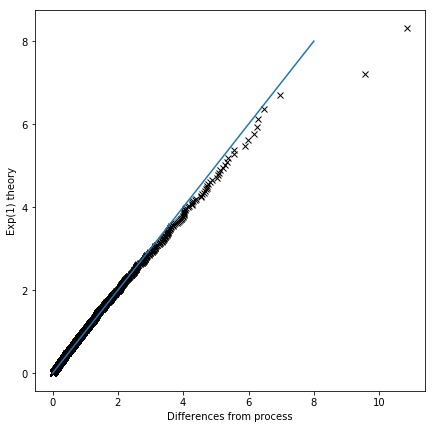

In [7]:
fig, ax = plt.subplots(figsize=(7,7))

x = np.linspace(0, 1, len(diffs)+1)
x = (x[:-1] + x[1:]) / 2
y = - np.log(1-x)
ax.scatter(diffs, y, marker="x", color="black", linewidth=1)
m=8
ax.plot([0,m], [0, m])
ax.set(xlabel="Differences from process", ylabel="Exp(1) theory")
None

# Predict

Simulate 200 "days" of process for various $\mu, \theta, \omega$.  For each $T=100,101,\cdots,199$ we:
- Look at the process up to $T$
- Repeatedly simulate the next day
- Compute the distribution of the number of points we get.

In [8]:
def simulate(mu=2, omega=5, theta=0.5):
    hawkes = Hawkes()
    hawkes.mu = mu
    hawkes.omega = omega
    hawkes.theta = theta
    return hawkes, hawkes.simulate([], 0, 1000)

def plot_simulation(points, hawkes, xrange=(50,100)):
    fig, ax = plt.subplots(figsize=(16,5))

    x = np.linspace(50, 100, 2000)
    y = [hawkes.intensity(points, t) for t in x]
    ax.plot(x, y, color="grey")

    ax.scatter(points, np.random.random(len(points))*.01, marker="x", color="black")
    ax.set(xlim=xrange)

    return fig

Result = collections.namedtuple("Result", "dist actual int intint")

def predict(points, hawkes, Trange=(100,1000), trials=100):
    results = []
    for T in range(*Trange):
        counts = []
        for _ in range(trials):
            current_points = points[points<T]
            new_points = hawkes.simulate(current_points, T, T+1)
            new_points = new_points[new_points < T+1]
            counts.append( len(new_points) )
        intint = np.mean([hawkes.intensity(current_points, t) for t in np.linspace(T,T+1,100)[1:]])
        result = Result(collections.Counter(counts),
                        len(points[(points>=T)&(points<T+1)]),
                        hawkes.intensity(current_points, T+1/2),
                        intint)
        results.append(result)
    return results

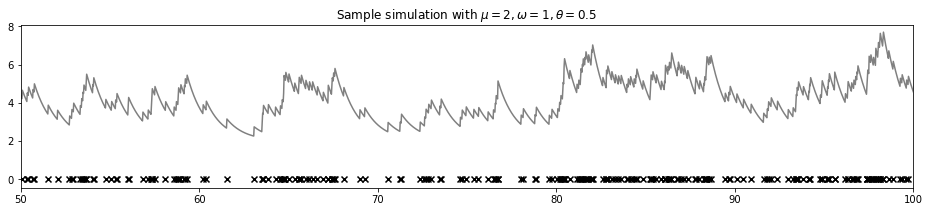

In [9]:
hawkes, points = simulate(mu=2, omega=1, theta=0.5)
fig = plot_simulation(points, hawkes)
fig.set_size_inches(16, 3)
fig.axes[0].set_title("Sample simulation with $\mu=2, \omega=1, \\theta=0.5$")
fig.savefig("../hawkes_sample.pdf")

In [10]:
results1 = predict(points, hawkes)

hawkes, points = simulate(mu=1, omega=1, theta=0.2)
results2 = predict(points, hawkes)

hawkes, points = simulate(mu=1, omega=50, theta=0.5)
results3 = predict(points, hawkes)

In [11]:
for results in [results1, results2, results3]:
    print(np.percentile([r.int - r.intint for r in results], 2),
     np.percentile([r.int - r.intint for r in results], 50),
     np.percentile([r.int - r.intint for r in results], 98))

-0.102864167011 -0.0439021239042 -0.0101751581279
-0.0158825369134 -0.00501678715448 -0.000237895304327
-0.180213539891 -1.33226762955e-15 0.0


In [12]:
def plot_bar(ax, x, y, cutoff=0.0001):
    ax.bar(x, y, color="grey")
    i = x.index(0)
    ax.bar([0], y[i], color="black")
    ax.set(xlabel="estimated - actual", ylabel="Relative count")
    
    y = np.asarray(y)
    m = y < (cutoff * np.sum(y))
    want = np.asarray(x)[~m]
    ax.set(xlim=[np.min(want) - 1/2, np.max(want) + 1/2])
    
def plot_diffs(ax, diffs):
    di = np.sort(diffs)
    low, high = np.percentile(di, 2), np.percentile(di, 98)
    low, high = int(np.floor(low))-2, int(np.ceil(high))+2
    ax.hist(di, color="grey", bins=np.arange(low,high+1))
    ax.set(xlabel="estimated - actual", ylabel="Relative count")
    ax.set(xlim=[low, high])

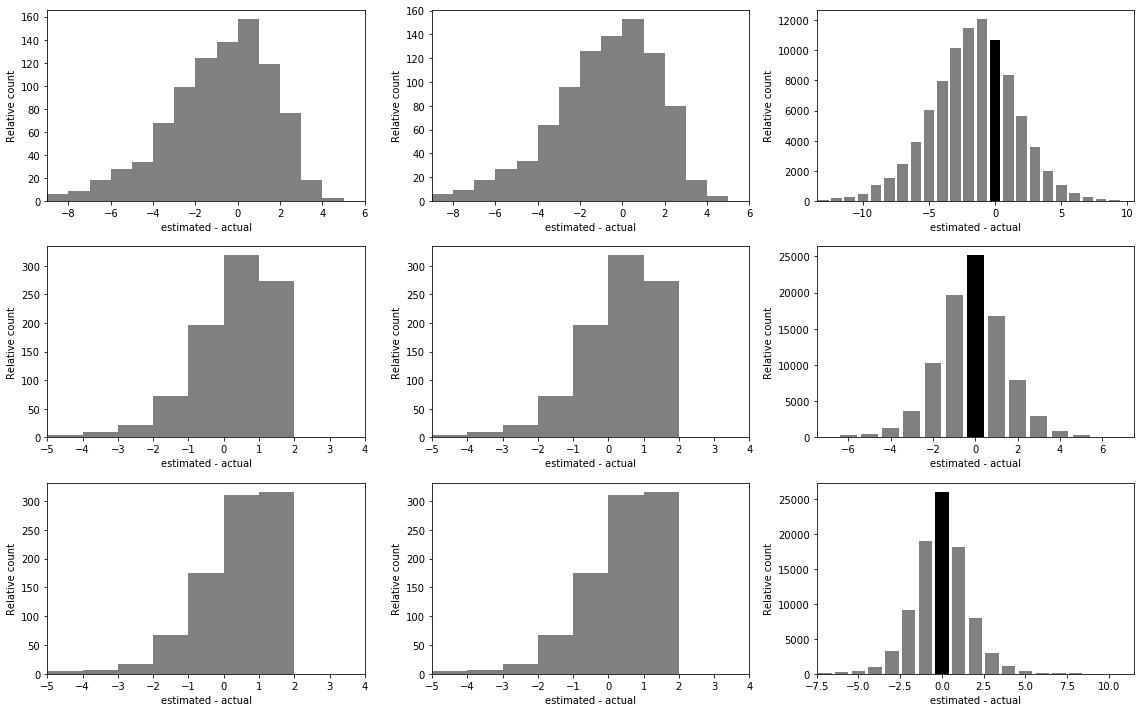

In [13]:
fig, axesall = plt.subplots(nrows=3, ncols=3, figsize=(16,10))

for axes, results in zip(axesall, [results1, results2, results3]):
    plot_diffs(axes[0], [r.int - r.actual for r in results])
    plot_diffs(axes[1], [r.intint - r.actual for r in results])

    error_counts = collections.defaultdict(int)
    for result in results:
        for count, num in result.dist.items():
            error_counts[count - result.actual] += num

    x = list(error_counts)
    y = list(error_counts.values())
    plot_bar(axes[2], x, y)

    fig.tight_layout()

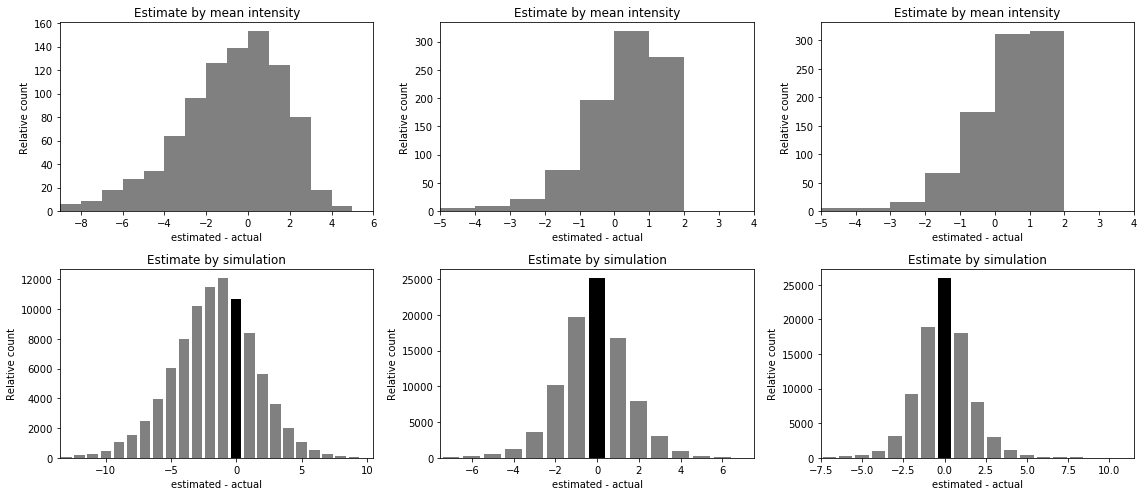

In [14]:
fig, axesall = plt.subplots(nrows=2, ncols=3, figsize=(16,7))

for axes, results in zip(axesall.T, [results1, results2, results3]):
    plot_diffs(axes[0], [r.intint - r.actual for r in results])

    error_counts = collections.defaultdict(int)
    for result in results:
        for count, num in result.dist.items():
            error_counts[count - result.actual] += num

    x = list(error_counts)
    y = list(error_counts.values())
    plot_bar(axes[1], x, y)
    
    axes[0].set_title("Estimate by mean intensity")
    axes[1].set_title("Estimate by simulation")

    fig.tight_layout()

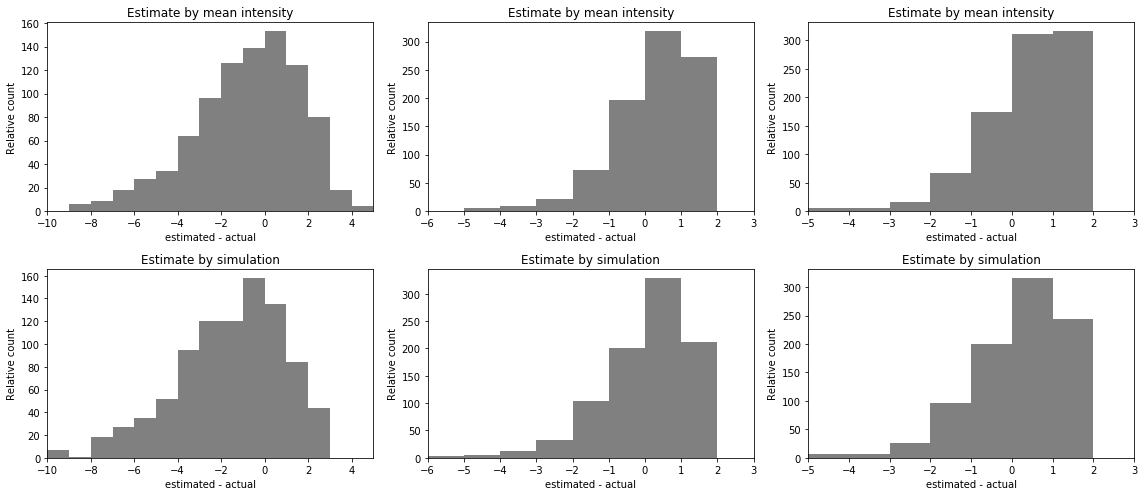

In [15]:
fig, axesall = plt.subplots(nrows=2, ncols=3, figsize=(16,7))

for axes, results in zip(axesall.T, [results1, results2, results3]):
    plot_diffs(axes[0], [r.intint - r.actual for r in results])
    diffs = []
    for result in results:
        d = sum((count - result.actual)*num for count, num in result.dist.items())
        d /= sum(num for count, num in result.dist.items())
        diffs.append(d)
    plot_diffs(axes[1], diffs)
    
    axes[0].set_title("Estimate by mean intensity")
    axes[1].set_title("Estimate by simulation")
    x11, x12 = axes[0].get_xlim()
    x21, x22 = axes[1].get_xlim()
    for ax in axes:
        ax.set(xlim=[min(x11,x21), max(x12,x22)-1])

    fig.tight_layout()

In [16]:
fig.savefig("../hawkes_predictions.pdf")